In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
from utils import display_img, process
from latent_dataset import WPlusLatentsDataset
from SAE import SparseAutoencoder
from torch.utils.data import DataLoader
from evaluate_saes import test_reconstructions
import einops

In [2]:
device = 'mps'

In [3]:
TRAIN_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
train_data = WPlusLatentsDataset(TRAIN_PATH)
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [4]:
SAE = SparseAutoencoder(latent_dim = 512, hidden_dim = 1024, sparsity_lambda = 0.5, device = device).to(device)

In [5]:
def train_sae_epoch(sae, loader, optimizer):
    total_losses = []
    reconstruction_losses = []
    sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        optimizer.zero_grad()
        batch = batch.to(sae.device)
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        total_loss.backward()
        optimizer.step()
        total_losses.append(total_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        sparsity_losses.append(sparsity_loss.item())
    return total_losses, reconstruction_losses, sparsity_losses

def train_sae(sae, train_loader, val_loader, optimizer, num_epochs, resampling_epochs):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    eval_losses = []
    eval_recon_losses = []
    eval_sparsity_losses = []
    for i in range(num_epochs):
        print(f'Starting epoch {i}!')
        total_losses, reconstruction_losses, sparsity_losses = train_sae_epoch(sae, train_loader, optimizer)
        all_total_losses.extend(total_losses)
        all_reconstruction_losses.extend(reconstruction_losses)
        all_sparsity_losses.extend(sparsity_losses)
        avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)
        eval_losses.append(avg_total_loss)
        eval_recon_losses.append(avg_recon_loss)
        eval_sparsity_losses.append(avg_sparsity_loss)
        print(f'Evaluation loss: {avg_total_loss}, Reconstruction loss: {avg_recon_loss}, Sparsity Loss: {avg_sparsity_loss}')
        if i in resampling_epochs:
            batch = next(iter(train_loader))
            with torch.no_grad():
                reconstructions, latents = sae(batch)
            sae.resample_dead_features(batch, latents, activation_threshold = 1e-4)
        print('\n')
    return all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses

@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [6]:
optimizer = torch.optim.Adam(params = SAE.parameters(), lr = 1e-3)

In [7]:
all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses = train_sae(SAE, train_loader, val_loader, optimizer, 10, set())

Starting epoch 0!


100%|██████████| 32/32 [00:03<00:00,  8.00it/s]


Evaluation loss: 0.07754273153841496, Reconstruction loss: 0.03620195365510881, Sparsity Loss: 0.08268155576661229


Starting epoch 1!


100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


Evaluation loss: 0.06624000309966505, Reconstruction loss: 0.02999013802036643, Sparsity Loss: 0.07249972969293594


Starting epoch 2!


100%|██████████| 32/32 [00:03<00:00,  8.00it/s]


Evaluation loss: 0.06184728187508881, Reconstruction loss: 0.026919542928226292, Sparsity Loss: 0.0698554776608944


Starting epoch 3!


100%|██████████| 32/32 [00:04<00:00,  7.98it/s]


Evaluation loss: 0.05910403770394623, Reconstruction loss: 0.024544789514038712, Sparsity Loss: 0.06911849649623036


Starting epoch 4!


100%|██████████| 32/32 [00:04<00:00,  7.50it/s]


Evaluation loss: 0.05720148631371558, Reconstruction loss: 0.022496927762404084, Sparsity Loss: 0.06940911640413105


Starting epoch 5!


100%|██████████| 32/32 [00:03<00:00,  8.02it/s]


Evaluation loss: 0.0557300066575408, Reconstruction loss: 0.020654202613513917, Sparsity Loss: 0.07015160820446908


Starting epoch 6!


100%|██████████| 32/32 [00:03<00:00,  8.14it/s]


Evaluation loss: 0.054656638065353036, Reconstruction loss: 0.019173441745806485, Sparsity Loss: 0.07096639182418585


Starting epoch 7!


100%|██████████| 32/32 [00:04<00:00,  7.98it/s]


Evaluation loss: 0.05377985897939652, Reconstruction loss: 0.01796603889670223, Sparsity Loss: 0.07162764016538858


Starting epoch 8!


100%|██████████| 32/32 [00:03<00:00,  8.58it/s]


Evaluation loss: 0.053088077693246305, Reconstruction loss: 0.016905242577195168, Sparsity Loss: 0.07236567023210227


Starting epoch 9!


100%|██████████| 32/32 [00:04<00:00,  7.97it/s]

Evaluation loss: 0.05254094768315554, Reconstruction loss: 0.016087747819256037, Sparsity Loss: 0.07290639961138368




In [8]:
total_losses, reconstruction_losses, sparsity_losses = torch.tensor(all_total_losses), torch.tensor(all_reconstruction_losses), torch.tensor(all_sparsity_losses)

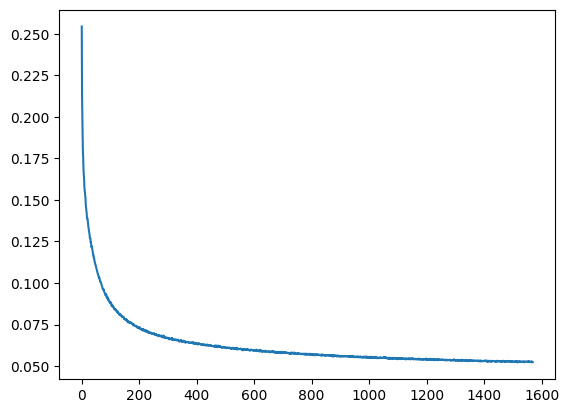

In [9]:
plt.plot(torch.clamp(total_losses, 0, 0.5))
plt.show()

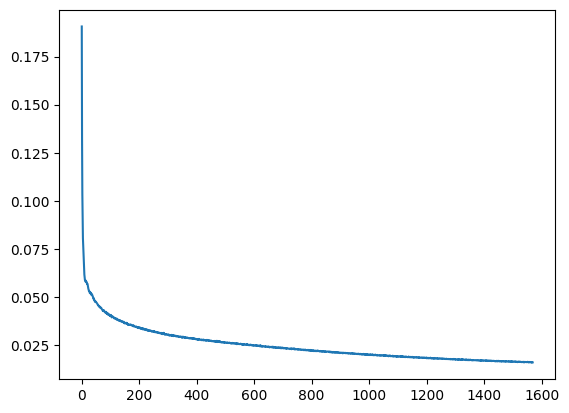

In [10]:
plt.plot(torch.clamp(reconstruction_losses, 0, 0.5))
plt.show()

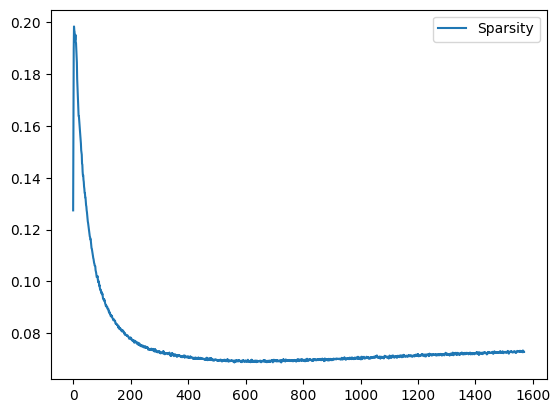

In [28]:
plt.plot(torch.clamp(sparsity_losses, 0, 0.5), label = 'Sparsity')
plt.legend()
plt.show()

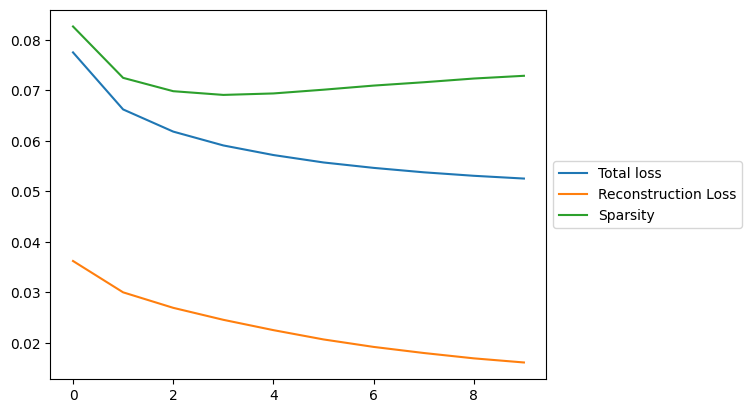

In [24]:
plt.plot(eval_losses, label = 'Total loss')
plt.plot(eval_recon_losses, label = 'Reconstruction Loss')
plt.plot(eval_sparsity_losses, label = 'Sparsity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Evaluation

In [13]:
VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [14]:
@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [15]:
avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)

100%|██████████| 32/32 [00:03<00:00,  9.41it/s]


# Visualize Some Reconstructions

In [16]:
import dnnlib
import legacy
from latent_dataset import save_latents

In [17]:
# downloaded from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files

FILEPATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/load_pretrained_stylegan/stylegan2-celebahq-256x256.pkl'
with dnnlib.util.open_url(FILEPATH) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].eval().to("mps")

Original Images:


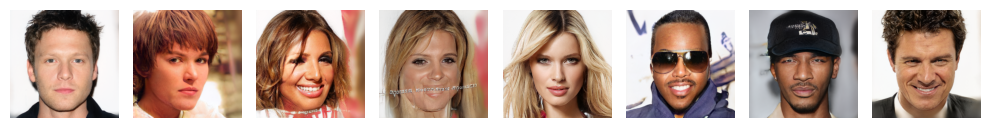

Reconstructed Images


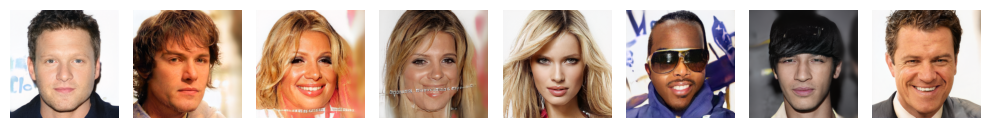

In [18]:
imgs, reconstructed_imgs = test_reconstructions(G, SAE, train_loader, h = 1, w = 8, display = True)